In [1]:
import random
import math

def network_random_points_1(amount, region, radius):
    """
    Gera pontos aleatórios maximizando a cobertura da região, mantendo conectividade.
    
    Parâmetros:
    - amount: número de pontos a serem gerados
    - region: tuple (x_min, y_min, x_max, y_max) definindo a região retangular
    - radius: raio de conexão entre pontos
    - max_attempts: tentativas máximas para encontrar posição válida para cada ponto
    
    Retorna:
    - Lista de tuples (x, y) com as coordenadas dos pontos
    """
    
    # Verifica se a quantidade é válida
    if amount <= 0:
        return []
    
    # Determina os limites do retângulo
    x_min = region[0]
    y_min = region[1]
    x_max = region[2]
    y_max = region[3]
    
    # Gera o primeiro ponto aleatoriamente dentro do retângulo
    pontos = []
    x = random.uniform(x_min, x_max)
    y = random.uniform(y_min, y_max)
    pontos.append((x, y))
    
    # Gera os demais pontos
    while len(pontos) < amount:
        # Escolhe um ponto existente aleatoriamente para ser a âncora
        ancora = random.choice(pontos)
        
        # Gera um ângulo aleatório
        angulo = random.uniform(0, 2 * math.pi)
        
        # Gera uma distância aleatória dentro do raio
        distancia = random.uniform(0, radius)
        
        # Calcula as novas coordenadas
        novo_x = ancora[0] + distancia * math.cos(angulo)
        novo_y = ancora[1] + distancia * math.sin(angulo)
        
        # Verifica se o novo ponto está dentro do retângulo
        if (x_min <= novo_x <= x_max) and (y_min <= novo_y <= y_max):
            pontos.append((novo_x, novo_y))
        else:
            # Se estiver fora, tenta novamente
            continue
    
    return pontos

In [2]:
import random
import math
import numpy as np

def network_random_points_2(amount, region, radius, max_attempts=100):
    """
    Gera pontos aleatórios maximizando a cobertura da região, mantendo conectividade.
    
    Parâmetros:
    - amount: número de pontos a serem gerados
    - region: tuple (x_min, y_min, x_max, y_max) definindo a região retangular
    - radius: raio de conexão entre pontos
    - max_attempts: tentativas máximas para encontrar posição válida para cada ponto
    
    Retorna:
    - Lista de tuples (x, y) com as coordenadas dos pontos
    """
    
    if amount <= 0:
        return []
    
    x_min, y_min, x_max, y_max = region
    points = []
    
    # 1. Primeiro ponto no centro da região
    first_x = (x_min + x_max) / 2
    first_y = (y_min + y_max) / 2
    points.append((first_x, first_y))
    
    # 2. Pontos subsequentes com estratégia de maximização
    while len(points) < amount:
        best_point = None
        max_min_distance = 0
        
        # Tentativa de encontrar o ponto que maximiza a distância mínima aos existentes
        for _ in range(max_attempts):
            # Escolhe um ponto âncora aleatório
            anchor = random.choice(points)
            
            # Gera direção e distância (priorizando distâncias maiores)
            angle = random.uniform(0, 2 * math.pi)
            distance = random.uniform(0.7 * radius, radius)  # Prefere valores próximos ao raio máximo
            
            new_x = anchor[0] + distance * math.cos(angle)
            new_y = anchor[1] + distance * math.sin(angle)
            
            # Verifica se está dentro da região
            if not (x_min <= new_x <= x_max and y_min <= new_y <= y_max):
                continue
                
            # Calcula a distância mínima aos pontos existentes
            if points:
                min_dist = min(math.sqrt((new_x-p[0])**2 + (new_y-p[1])**2) for p in points)
            else:
                min_dist = float('inf')
                
            # Atualiza o melhor ponto encontrado
            if min_dist > max_min_distance:
                max_min_distance = min_dist
                best_point = (new_x, new_y)
        
        # Adiciona o melhor ponto encontrado ou um aleatório se não encontrar
        if best_point:
            points.append(best_point)
        else:
            # Fallback: adiciona um ponto aleatório conectado
            anchor = random.choice(points)
            angle = random.uniform(0, 2 * math.pi)
            distance = random.uniform(0, radius)
            new_x = anchor[0] + distance * math.cos(angle)
            new_y = anchor[1] + distance * math.sin(angle)
            
            # Garante que está dentro da região
            new_x = np.clip(new_x, x_min, x_max)
            new_y = np.clip(new_y, y_min, y_max)
            points.append((new_x, new_y))
    
    # 3. Otimização final para melhor distribuição
    for i in range(1, len(points)):  # Não movemos o primeiro ponto
        if random.random() < 0.3:  # Probabilidade de ajuste
            current_point = points[i]
            neighbors = [p for p in points if math.sqrt((p[0]-current_point[0])**2 + 
                                           (p[1]-current_point[1])**2) < radius * 1.5]
            
            if neighbors:
                # Move o ponto para longe dos vizinhos enquanto mantém conectividade
                mean_x = sum(p[0] for p in neighbors) / len(neighbors)
                mean_y = sum(p[1] for p in neighbors) / len(neighbors)
                
                # Direção oposta à média dos vizinhos
                dir_x = current_point[0] - mean_x
                dir_y = current_point[1] - mean_y
                norm = math.sqrt(dir_x**2 + dir_y**2)
                
                if norm > 0:
                    dir_x, dir_y = dir_x/norm, dir_y/norm
                    move_dist = min(radius * 0.5, norm)
                    new_x = current_point[0] + dir_x * move_dist
                    new_y = current_point[1] + dir_y * move_dist
                    
                    # Mantém dentro da região
                    new_x = np.clip(new_x, x_min, x_max)
                    new_y = np.clip(new_y, y_min, y_max)
                    
                    # Verifica se ainda está conectado
                    if any(math.sqrt((p[0]-new_x)**2 + (p[1]-new_y)**2) <= radius for p in neighbors):
                        points[i] = (new_x, new_y)
    
    return points

In [3]:
import random
import math
import numpy as np
from collections import deque

def network_random_points(amount, region, radius, max_attempts=100):
    """
    Gera pontos aleatórios maximizando a cobertura da região, garantindo que o grafo seja conexo.
    
    Parâmetros:
    - amount: número de pontos a serem gerados
    - region: tuple (x_min, y_min, x_max, y_max) definindo a região retangular
    - radius: raio de conexão entre pontos
    - max_attempts: tentativas máximas para encontrar posição válida para cada ponto
    
    Retorna:
    - Lista de tuples (x, y) com as coordenadas dos pontos
    """
    
    if amount <= 0:
        return []
    
    x_min, y_min, x_max, y_max = region
    points = []
    
    # 1. Primeiro ponto no centro da região
    first_x = (x_min + x_max) / 2
    first_y = (y_min + y_max) / 2
    points.append((first_x, first_y))
    
    # Função para verificar se o grafo é conexo
    def is_connected(points, radius):
        if not points:
            return True
        visited = set()
        queue = deque([0])
        adjacency = {i: [] for i in range(len(points))}
        
        # Construir lista de adjacência
        for i in range(len(points)):
            for j in range(i+1, len(points)):
                if math.dist(points[i], points[j]) <= radius:
                    adjacency[i].append(j)
                    adjacency[j].append(i)
        
        # BFS para verificar conectividade
        while queue:
            node = queue.popleft()
            if node not in visited:
                visited.add(node)
                queue.extend(adjacency[node])
        
        return len(visited) == len(points)
    
    # 2. Geração de pontos com garantia de conectividade
    while len(points) < amount:
        best_point = None
        max_min_distance = 0
        
        for _ in range(max_attempts):
            # Escolhe um ponto âncora aleatório entre os pontos conectados
            connected_indices = list(range(len(points)))  # Todos inicialmente conectados
            anchor_idx = random.choice(connected_indices)
            anchor = points[anchor_idx]
            
            angle = random.uniform(0, 2 * math.pi)
            distance = random.uniform(0.5 * radius, radius)  # Intervalo mais conservador
            
            new_x = anchor[0] + distance * math.cos(angle)
            new_y = anchor[1] + distance * math.sin(angle)
            
            # Verifica se está dentro da região
            if not (x_min <= new_x <= x_max and y_min <= new_y <= y_max):
                continue
                
            # Ponto candidato temporário
            temp_points = points + [(new_x, new_y)]
            
            # Verifica conectividade
            if is_connected(temp_points, radius):
                # Calcula distância mínima para maximizar cobertura
                min_dist = min(math.dist((new_x, new_y), p) for p in points)
                if min_dist > max_min_distance:
                    max_min_distance = min_dist
                    best_point = (new_x, new_y)
        
        # Adiciona o melhor ponto encontrado ou usa estratégia alternativa
        if best_point:
            points.append(best_point)
        else:
            # Estratégia alternativa: conecta ao ponto mais próximo desconectado
            if len(points) > 1:
                # Encontra componentes desconexos
                components = []
                visited = set()
                for i in range(len(points)):
                    if i not in visited:
                        component = []
                        queue = deque([i])
                        while queue:
                            node = queue.popleft()
                            if node not in visited:
                                visited.add(node)
                                component.append(node)
                                for j in range(len(points)):
                                    if j != node and math.dist(points[node], points[j]) <= radius:
                                        queue.append(j)
                        components.append(component)
                
                # Se houver múltiplos componentes, conecta-os
                if len(components) > 1:
                    # Escolhe dois componentes aleatórios
                    comp1, comp2 = random.sample(components, 2)
                    point1 = points[random.choice(comp1)]
                    point2 = points[random.choice(comp2)]
                    
                    # Gera ponto intermediário que conecta ambos
                    mid_x = (point1[0] + point2[0]) / 2
                    mid_y = (point1[1] + point2[1]) / 2
                    direction = math.atan2(point2[1]-point1[1], point2[0]-point1[0])
                    
                    # Ajusta para ficar dentro do raio de ambos
                    new_x = mid_x + random.uniform(-0.3*radius, 0.3*radius) * math.sin(direction)
                    new_y = mid_y + random.uniform(-0.3*radius, 0.3*radius) * math.cos(direction)
                    
                    # Garante que está dentro da região
                    new_x = np.clip(new_x, x_min, x_max)
                    new_y = np.clip(new_y, y_min, y_max)
                    
                    points.append((new_x, new_y))
                    continue
            
            # Fallback: ponto aleatório conectado ao componente principal
            anchor = random.choice(points)
            angle = random.uniform(0, 2 * math.pi)
            distance = random.uniform(0, radius)
            new_x = anchor[0] + distance * math.cos(angle)
            new_y = anchor[1] + distance * math.sin(angle)
            
            new_x = np.clip(new_x, x_min, x_max)
            new_y = np.clip(new_y, y_min, y_max)
            points.append((new_x, new_y))
    
    # 3. Verificação final de conectividade
    if not is_connected(points, radius):
        # Força conexão se necessário
        components = []
        visited = set()
        for i in range(len(points)):
            if i not in visited:
                component = []
                queue = deque([i])
                while queue:
                    node = queue.popleft()
                    if node not in visited:
                        visited.add(node)
                        component.append(node)
                        for j in range(len(points)):
                            if j != node and math.dist(points[node], points[j]) <= radius:
                                queue.append(j)
                components.append(component)
        
        while len(components) > 1:
            # Conecta dois componentes aleatórios
            comp1, comp2 = random.sample(components, 2)
            point1 = points[random.choice(comp1)]
            point2 = points[random.choice(comp2)]
            
            # Adiciona ponto intermediário
            mid_x = (point1[0] + point2[0]) / 2
            mid_y = (point1[1] + point2[1]) / 2
            points.append((mid_x, mid_y))
            
            # Recalcula componentes
            components = []
            visited = set()
            for i in range(len(points)):
                if i not in visited:
                    component = []
                    queue = deque([i])
                    while queue:
                        node = queue.popleft()
                        if node not in visited:
                            visited.add(node)
                            component.append(node)
                            for j in range(len(points)):
                                if j != node and math.dist(points[node], points[j]) <= radius:
                                    queue.append(j)
                    components.append(component)
    
    return points

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle

def plot_network(points, region, radius):
    """
    Plota pontos com círculos de alcance e conexões entre pontos dentro do mesmo raio
    
    Parâmetros:
    - points: lista de tuples (x, y) com as coordenadas dos pontos
    - region: tuple (x_min, y_min, x_max, y_max) definindo a região retangular
    - radius: raio de alcance para conexões entre pontos
    """
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Configuração do plot
    ax.set_xlim(region[0], region[2])
    ax.set_ylim(region[1], region[3])
    ax.set_aspect('equal')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_title(f'Rede com {len(points)} nós (raio = {radius})')
    
    # Desenha a região delimitada
    rect = plt.Rectangle((region[0], region[1]), 
                         region[2]-region[0], region[3]-region[1],
                         fill=False, linestyle='--', edgecolor='red', linewidth=1)
    ax.add_patch(rect)
    
    # Desenha as arestas (conexões)
    for i in range(len(points)):
        for j in range(i+1, len(points)):
            distance = np.sqrt((points[i][0]-points[j][0])**2 + (points[i][1]-points[j][1])**2)
            if distance <= radius:
                ax.plot([points[i][0], points[j][0]], [points[i][1], points[j][1]], 
                        color='#999999', linewidth=1, alpha=0.7)
    
    # Desenha os círculos de alcance
    for (x, y) in points:
        circle = Circle((x, y), radius, 
                       fill=True, alpha=0.1,
                       edgecolor='lightblue', linewidth=1)
        ax.add_patch(circle)
    
    # Desenha os pontos (nós)
    for i, (x, y) in enumerate(points):
        ax.plot(x, y, 'o', markersize=10, color='#4ECDC4', markeredgecolor='black')
        ax.text(x, y, str(i), color='black', ha='center', va='center')
    
    plt.show()

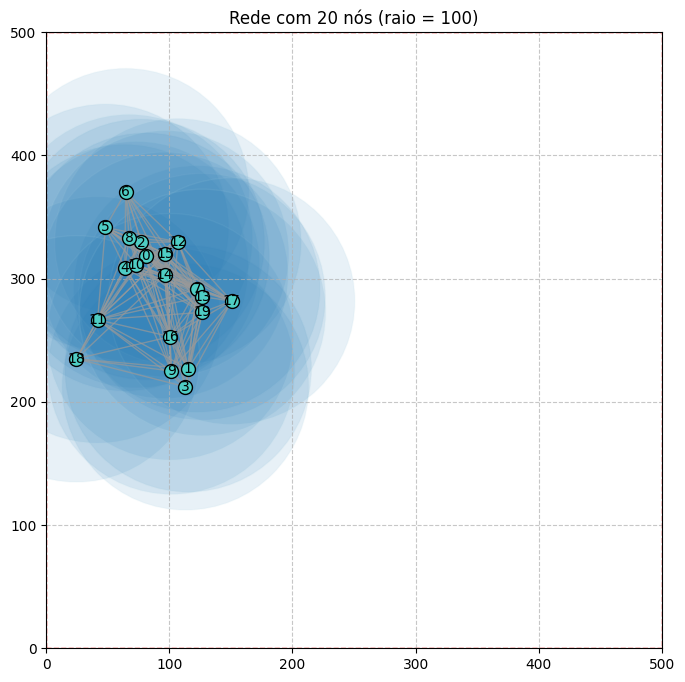

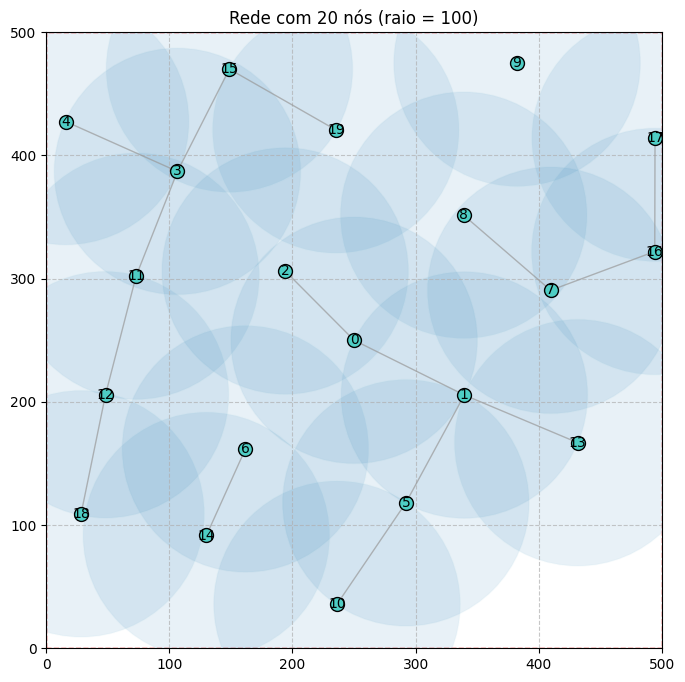

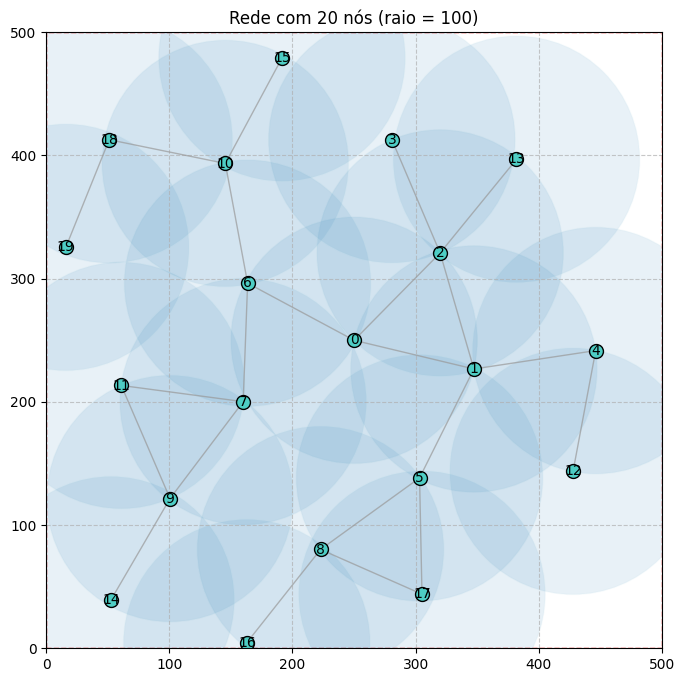

In [6]:
# Define a região (x_min, y_min, x_max, y_max)
region = (0, 0, 500, 500)
# Define o raio de alcance
radius = 100

# Gera 20 pontos com raio de alcance 3
points = network_random_points_1(20, region, radius)

# Plota a rede
plot_network(points, region, radius)

# Gera 20 pontos com raio de alcance 3
points = network_random_points_2(20, region, radius)

# Plota a rede
plot_network(points, region, radius)

# Gera 20 pontos com raio de alcance 3
points = network_random_points(20, region, radius)

# Plota a rede
plot_network(points, region, radius)